Base results directory: /home/users/ntu/chong032/slimsc/prune/results/R1-Distill-Qwen-14B/gpqa_diamond

--- Aggregating data from experiments ---
  -> Warning: Could not parse strategy from directory name: fewest_thoughts_n10_thresh0.70
  -> Warning: Could not parse strategy from directory name: fewest_thoughts_n10_thresh0.72
  -> Warning: Could not parse strategy from directory name: sc_10_control_stream
  -> Warning: Could not parse strategy from directory name: sc_20_control_stream

Processing experiment: sim_prune_diversity_n10_thresh0.74 (Strategy: diversity, Label: diversity (n=10, thr=0.74))
  -> Processed 198 valid summary files.
  -> Stored data for 198 questions. Max step in exp: 31

Processing experiment: sim_prune_diversity_n10_thresh0.75 (Strategy: diversity, Label: diversity (n=10, thr=0.75))
  -> Processed 198 valid summary files.
  -> Stored data for 198 questions. Max step in exp: 19

Processing experiment: sim_prune_diversity_n10_thresh0.76 (Strategy: diversity, Label

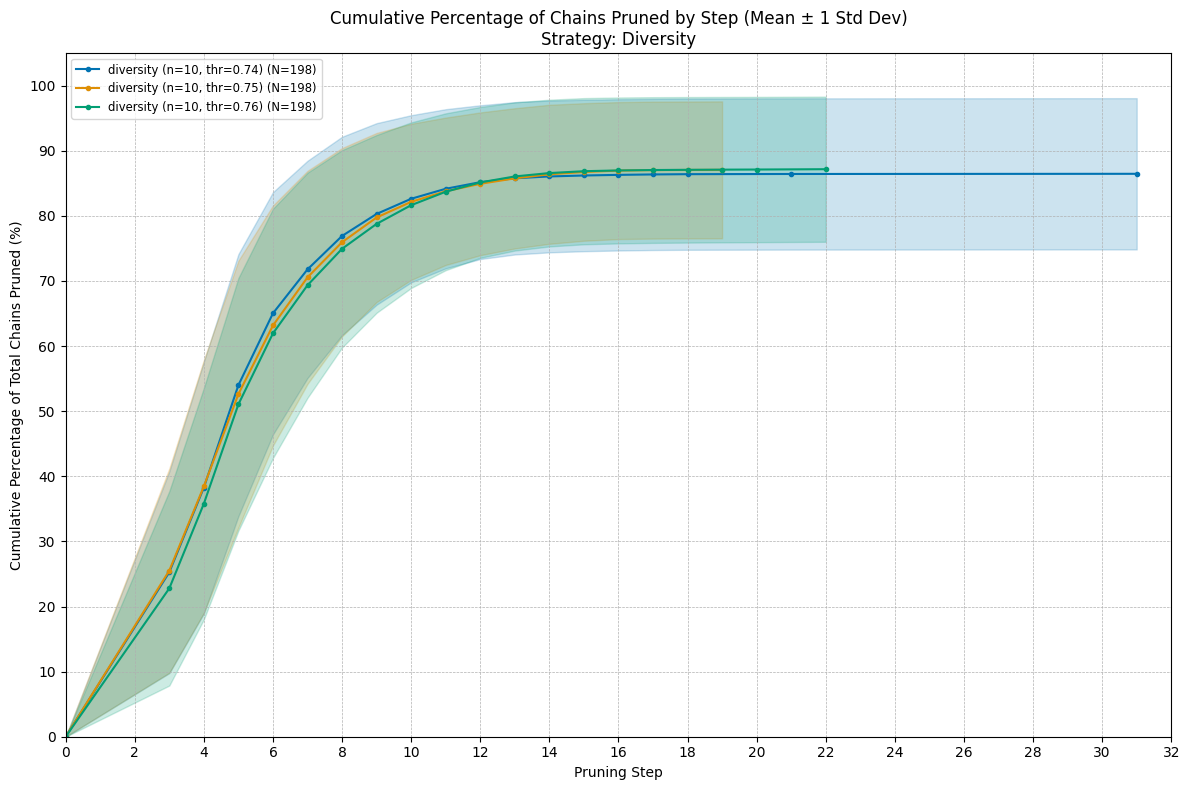


Generating plot for strategy: fewest
  -> Calculated stats for 'fewest (n=10, thr=0.74)' (198 questions).
  -> Calculated stats for 'fewest (n=10, thr=0.75)' (198 questions).
  -> Calculated stats for 'fewest (n=10, thr=0.76)' (198 questions).


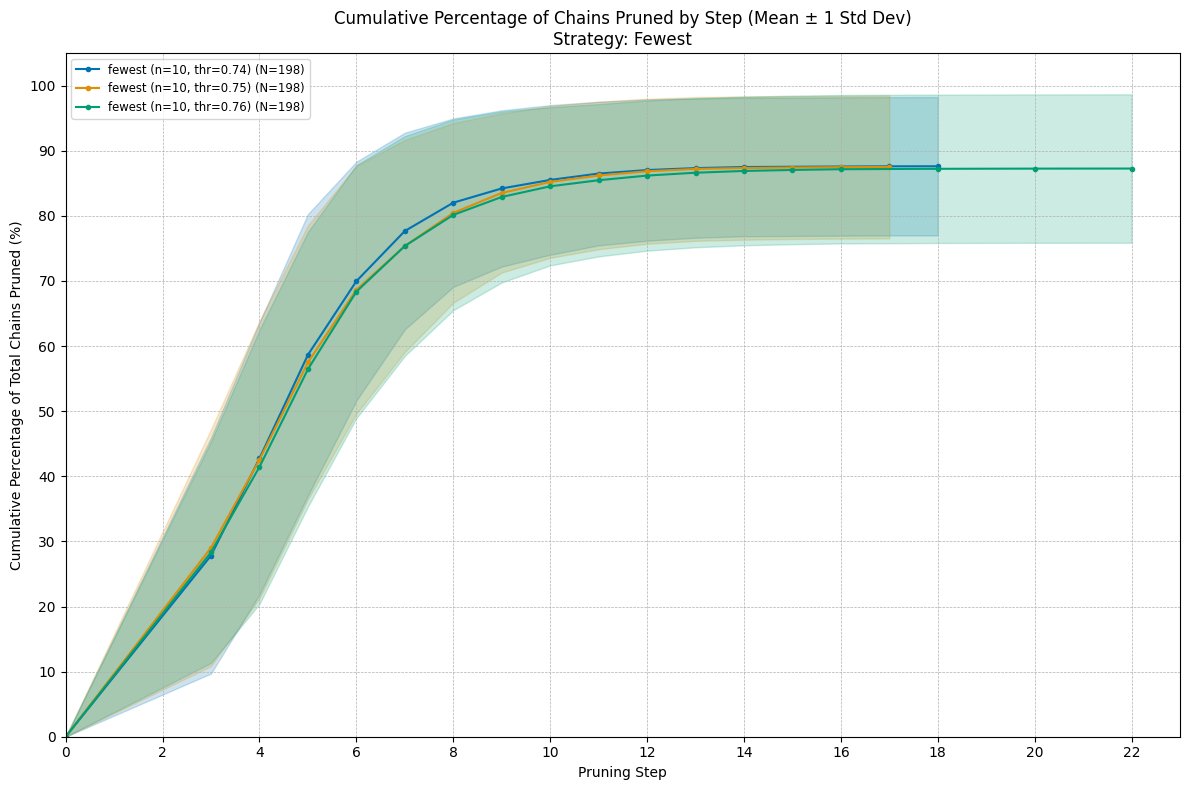


Generating plot for strategy: most
  -> Calculated stats for 'most (n=10, thr=0.74)' (198 questions).
  -> Calculated stats for 'most (n=10, thr=0.75)' (198 questions).
  -> Calculated stats for 'most (n=10, thr=0.76)' (198 questions).


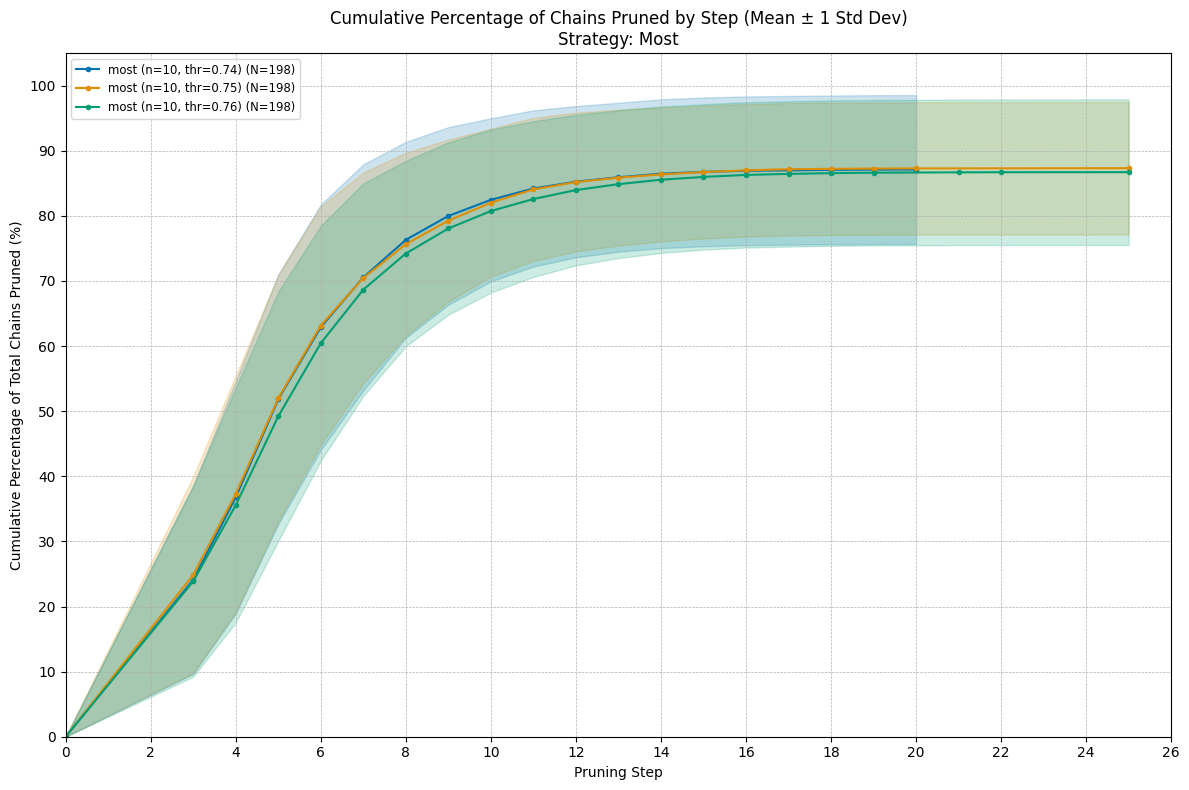


Finished processing all experiments and generating grouped plots with confidence bands.


In [9]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import os
import re
from scipy import interpolate
import seaborn as sns

# --- Helper Function to Parse Experiment Name ---
def parse_experiment_name(dir_name):
    """
    Parses the experiment directory name to extract strategy and parameters.
    Returns a tuple: (strategy, label) or (None, None) if parsing fails.
    """
    parts = dir_name.split('_prune_')
    if len(parts) != 2:
        # Handle cases without '_prune_' like 'baseline_n10'
        if 'baseline' in dir_name:
             strategy = 'baseline'
             label = dir_name # Use full name as label
             return strategy, label
        print(f"  -> Warning: Could not parse strategy from directory name: {dir_name}")
        return None, None

    strategy_and_params = parts[1]
    strategy_parts = strategy_and_params.split('_')
    
    strategy = strategy_parts[0]
    
    params_label_parts = []
    n_match = re.search(r'_n(\d+)', dir_name) # Check full name for n
    if n_match:
        params_label_parts.append(f"n={n_match.group(1)}")
        
    thresh_match = re.search(r'_thresh([\d.]+)', strategy_and_params)
    if thresh_match:
        params_label_parts.append(f"thr={thresh_match.group(1)}")
        
    max_active_match = re.search(r'_max_active(\d+)', strategy_and_params)
    if max_active_match:
         params_label_parts.append(f"max_act={max_active_match.group(1)}")

    if not params_label_parts and len(strategy_parts) > 1:
         params_label_parts.append("_".join(strategy_parts[1:]))
            
    label = f"{strategy} ({', '.join(params_label_parts)})" if params_label_parts else strategy
    label = label.replace('_', ' ') # Make label more readable

    # Map common strategy variations if needed
    if 'diversity' in strategy.lower():
        strategy_key = 'diversity'
    elif 'most_thoughts' in strategy.lower():
         strategy_key = 'most_thoughts'
    elif 'fewest_thoughts' in strategy.lower():
         strategy_key = 'fewest_thoughts'
    elif 'baseline' in strategy.lower():
        strategy_key = 'baseline' # Group baselines together
    else:
         strategy_key = strategy 
        
    return strategy_key, label


# --- Main Script ---

# Define the base directory containing the experiment results
notebook_dir = Path(os.getcwd()) # Assumes notebook is in slimsc/prune/plots/
base_results_dir = notebook_dir.parent / "results" / "R1-Distill-Qwen-14B" / "gpqa_diamond"
# Or define an absolute path:
# base_results_dir = Path("/path/to/your/slimsc/prune/results/R1-Distill-Qwen-14B/gpqa_diamond")

print(f"Base results directory: {base_results_dir}")

# Dictionary to hold data grouped by strategy
# Structure: { 'strategy_key': { 'experiment_label': {'per_question_raw': [...], 'details': {...} }, ... }, ... }
grouped_experiment_data = defaultdict(lambda: defaultdict(lambda: {'per_question_raw': [], 'details': {}}))
max_step_overall = 0 # Keep track of the max step across all experiments

if not base_results_dir.is_dir():
    print(f"ERROR: Base results directory not found at {base_results_dir}")
else:
    # --- Data Aggregation Phase ---
    print("\n--- Aggregating data from experiments ---")
    for experiment_dir in sorted(base_results_dir.iterdir()):
        if experiment_dir.is_dir():
            experiment_name = experiment_dir.name
            
            strategy, label = parse_experiment_name(experiment_name)
            if strategy is None:
                continue 

            print(f"\nProcessing experiment: {experiment_name} (Strategy: {strategy}, Label: {label})")
            summaries_dir = experiment_dir / "summaries"

            if not summaries_dir.is_dir():
                print(f"  -> Summaries directory not found: {summaries_dir}")
                continue

            experiment_question_data = [] # Store raw data per question for this experiment
            experiment_all_pruned_steps_union = set() # Unique steps across all questions in this experiment
            experiment_max_step = 0 # Max step within this experiment

            json_files_found = list(summaries_dir.glob("question_*_summary.json"))
            if not json_files_found:
                print(f"  -> No question summary JSON files found in {summaries_dir}")
                continue
                
            processed_files_count = 0
            for json_file in json_files_found:
                try:
                    with open(json_file, 'r') as f:
                        data = json.load(f)

                    n_start = data.get("n_chains_start", 0)
                    if n_start <= 0:
                        # print(f"  -> Skipping {json_file.name}, n_chains_start={n_start}")
                        continue
                        
                    processed_files_count += 1
                    question_pruned_steps = []
                    if "pruned_chain_details" in data:
                        for chain in data["pruned_chain_details"]:
                            if "pruned_at_step" in chain:
                                step = chain["pruned_at_step"]
                                question_pruned_steps.append(step)
                                experiment_all_pruned_steps_union.add(step)
                                experiment_max_step = max(experiment_max_step, step)
                                max_step_overall = max(max_step_overall, step) # Update global max step

                    # Store raw data needed for later CDF calculation per question
                    experiment_question_data.append({
                        'n_start': n_start,
                        'pruned_steps': question_pruned_steps
                    })

                except json.JSONDecodeError:
                    print(f"  -> Error decoding JSON from {json_file.name}")
                except Exception as e:
                    print(f"  -> Error processing file {json_file.name}: {e}")

            if not experiment_question_data:
                 print(f"  -> No valid question data found for experiment {experiment_name}.")
                 continue
                 
            print(f"  -> Processed {processed_files_count} valid summary files.")
            # Store collected data
            grouped_experiment_data[strategy][label]['per_question_raw'] = experiment_question_data
            grouped_experiment_data[strategy][label]['details']['all_steps_union'] = sorted(list(experiment_all_pruned_steps_union))
            grouped_experiment_data[strategy][label]['details']['max_step'] = experiment_max_step
            grouped_experiment_data[strategy][label]['details']['num_questions'] = len(experiment_question_data)
            print(f"  -> Stored data for {len(experiment_question_data)} questions. Max step in exp: {experiment_max_step}")


    # --- Calculation and Plotting Phase ---
    print("\n--- Calculating Statistics and Generating Plots ---")

    for strategy, experiments in grouped_experiment_data.items():
        print(f"\nGenerating plot for strategy: {strategy}")
        
        # Sort experiments by label for consistent plotting order
        sorted_experiment_labels = sorted(experiments.keys())
        
        if not sorted_experiment_labels:
            print(f"  -> No experiments found for strategy '{strategy}'. Skipping.")
            continue

        plt.figure(figsize=(12, 8)) # Slightly larger figure
        group_max_step = 0 # Find max step across all experiments *within this group*
        
        # --- Calculate Aggregated CDFs with Confidence Bands ---
        for label in sorted_experiment_labels:
            exp_data = experiments[label]
            question_raw_data = exp_data['per_question_raw']
            details = exp_data['details']
            
            num_questions = details['num_questions']
            if num_questions == 0:
                print(f"  -> Skipping '{label}': No question data.")
                continue
                
            # Use union of steps within the experiment as the common grid. Add 0.
            # If no steps were recorded at all, use just step 0.
            common_steps = np.array([0] + details['all_steps_union'])
            current_exp_max_step = details['max_step']
            group_max_step = max(group_max_step, current_exp_max_step) # Update group max step

            # Matrix to store interpolated percentages [question, step]
            interpolated_percentages = np.zeros((num_questions, len(common_steps)))

            for i, q_data in enumerate(question_raw_data):
                n_start = q_data['n_start']
                pruned_steps = q_data['pruned_steps']

                if n_start == 0: # Should have been filtered, but double check
                    interpolated_percentages[i, :] = np.nan # Mark as NaN if no chains started
                    continue

                if not pruned_steps:
                    # If no chains were pruned, percentage is 0 at all steps
                    q_plot_steps = np.array([0, current_exp_max_step + 1]) # Define steps up to max
                    q_plot_percentages = np.array([0.0, 0.0])
                else:
                    # Calculate CDF for this specific question
                    step_counts = Counter(pruned_steps)
                    sorted_q_steps = sorted(step_counts.keys())
                    cumulative_counts = np.cumsum([step_counts[step] for step in sorted_q_steps])
                    cumulative_percentage = (cumulative_counts / n_start) * 100
                    
                    # Create step function points (add 0)
                    q_plot_steps = np.array([0] + sorted_q_steps)
                    q_plot_percentages = np.array([0.0] + list(cumulative_percentage))

                    # Ensure the step function extends to the maximum step observed if needed for interpolation later
                    # This might not be strictly necessary if interp handles boundaries correctly, but can be safer
                    if q_plot_steps[-1] < current_exp_max_step:
                         q_plot_steps = np.append(q_plot_steps, current_exp_max_step + 1) # Add a point beyond max
                         q_plot_percentages = np.append(q_plot_percentages, q_plot_percentages[-1]) # Maintain last percentage


                # Interpolate this question's CDF onto the common steps grid for the experiment
                # Using linear interpolation here. For strict step function, logic would be more complex.
                # 'interp1d' with kind='previous' or 'next' might be closer to step func, but linear is common.
                # Using np.interp is simpler and handles boundaries
                # We need to handle cases where q_plot_steps might be empty or have single value if interp fails
                if len(q_plot_steps) > 1:
                    interp_func = interpolate.interp1d(q_plot_steps, q_plot_percentages, kind='linear', bounds_error=False, fill_value=(q_plot_percentages[0], q_plot_percentages[-1]))
                    interpolated_percentages[i, :] = interp_func(common_steps)
                    # Clamp values just in case interpolation goes slightly out of [0, 100] range due to floats
                    interpolated_percentages[i, :] = np.clip(interpolated_percentages[i, :], 0, 100)
                elif len(q_plot_steps) == 1: # Only step 0 (e.g. only unpruned)
                    interpolated_percentages[i, :] = q_plot_percentages[0] # Should be 0
                else: # No steps, likely already handled (n_start=0 or no pruned steps)
                     interpolated_percentages[i, :] = 0.0


            # --- Calculate Mean and Standard Deviation ---
            # Use nanmean/nanstd if we allowed NaNs earlier, otherwise mean/std is fine
            mean_percentages = np.mean(interpolated_percentages, axis=0)
            std_dev_percentages = np.std(interpolated_percentages, axis=0)
            
            # Define bands (e.g., Mean +/- 1 Std Dev)
            lower_band = np.maximum(0, mean_percentages - std_dev_percentages) # Don't go below 0%
            upper_band = np.minimum(100, mean_percentages + std_dev_percentages) # Don't exceed 100%

            # Store calculated stats for plotting
            exp_data['stats'] = {
                'common_steps': common_steps,
                'mean': mean_percentages,
                'lower': lower_band,
                'upper': upper_band,
                'num_questions': num_questions # Store count for potential annotation
            }
            print(f"  -> Calculated stats for '{label}' ({num_questions} questions).")

        # --- Plotting with Confidence Bands ---
        # colors = plt.cm.tab10(np.linspace(0, 1, len(sorted_experiment_labels))) # Get distinct colors
        colors = sns.color_palette('colorblind', n_colors=len(sorted_experiment_labels))

        for i, label in enumerate(sorted_experiment_labels):
            if 'stats' not in experiments[label]:
                continue # Skip if stats calculation failed

            stats = experiments[label]['stats']
            common_steps = stats['common_steps']
            mean_line = stats['mean']
            lower_band = stats['lower']
            upper_band = stats['upper']
            num_q = stats['num_questions']
            
            color = colors[i]
            
            # Plot the mean line
            line, = plt.plot(common_steps, mean_line, marker='.', linestyle='-', label=f"{label} (N={num_q})", color=color)
            
            # Add the confidence band using fill_between
            # Check if there's actually variance to plot band
            if np.any(upper_band > lower_band) and num_q > 1: # Only plot band if std dev > 0 and more than 1 question
                 plt.fill_between(common_steps, lower_band, upper_band, alpha=0.2, color=line.get_color())
            elif num_q <= 1:
                 print(f"  -> Note: Confidence band not shown for '{label}' (only {num_q} question(s)).")


        # --- Final Plot Setup ---
        plt.title(f"Cumulative Percentage of Chains Pruned by Step (Mean ± 1 Std Dev)\nStrategy: {strategy.replace('_', ' ').title()}")
        plt.xlabel("Pruning Step")
        plt.ylabel("Cumulative Percentage of Total Chains Pruned (%)")
        plt.ylim(0, 105) 
        plt.xlim(left=0, right=max(10, group_max_step + 1)) # Use max step from the group
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        tick_step = 2
        plt.xticks(np.arange(0, group_max_step + 2, step=tick_step))
        plt.yticks(np.arange(0, 101, 10))

        plt.legend(loc='best', fontsize='small') # Adjust legend location if needed
        
        plt.tight_layout()
        plt.show()

print("\nFinished processing all experiments and generating grouped plots with confidence bands.")